## Imports

In [28]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet 
import statsmodels.tsa.stattools as ts
 
from helper import clean_data
from helper import vix_prime_combine
from helper import dftest
from helper import split_data

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data loading & cleaning

In [36]:
pct_df, vix_close , prime, weekly_vix, monthly_vix = clean_data()
monthly_vix = pct_df.resample('M').sum()
vp_df = vix_prime_combine(monthly_vix,prime)

In [37]:
pct_df['prime'] = prime
pct_df.prime = pct_df.prime.fillna(method='ffill')
pct_df.prime = pct_df.prime.fillna(value=10)
weekly_pct = pct_df.resample('W').mean()

## Let's split data up into test and train

In [39]:
##create train & validation sets
df_len = weekly_pct.shape[0]
train_vix = weekly_pct.iloc[:df_len-52*4,0]
train_prime = weekly_pct.iloc[:df_len-52*4,1]
validation = weekly_pct.iloc[df_len-52*4:df_len-52*2,0]
validation_prime = weekly_pct.iloc[df_len-52*4-1:df_len-52*2-1,0]
test = weekly_pct.iloc[df_len-52*2:,0]

In [47]:
weekly_pct['ds']=weekly_pct.index

In [51]:
weekly_pct.columns = ['y', 'prime', 'ds']

In [54]:
prophet_df = weekly_pct[['y','ds']]

In [58]:
df_len = prophet_df.shape[0]
p_train = prophet_df.iloc[:df_len-52*4,:]
p_validation = prophet_df.iloc[df_len-52*4:df_len-52*2]


In [ ]:
# df_len = weekly_pct.shape[0]
# train = pct_df.iloc[:df_len-200,0]
# train = train.values
# validation = pct_df.iloc[df_len-200:df_len-100,0]
# validation = validation.values
# test = pct_df.iloc[df_len-100:,0]

## Default Prophet

In [33]:
from helper import RMSE
from helper import optimize_ar_rmse

In [34]:
from helper import format_prophet_data

In [ ]:
p_train,p_validation = format_prophet_data(train,validation)

In [61]:
m = Prophet()
m.fit(p_train)
#future = m.make_future_dataframe(periods=213)
forecast = m.predict(p_validation)
#m.plot_components(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


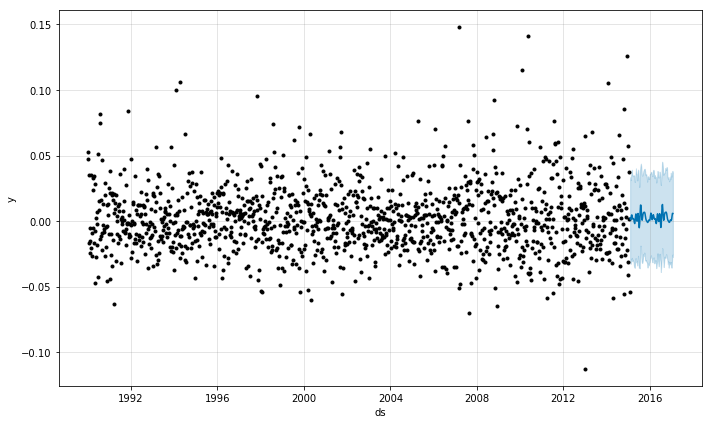

In [62]:
fig1 = m.plot(forecast)

In [63]:
join_df = forecast[['ds','yhat']]

In [64]:
join_df.set_index('ds',inplace=True)

In [65]:
p_validation['preds']=join_df['yhat']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


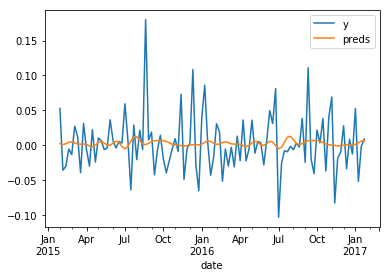

In [66]:
p_validation[['y','preds']].plot()

In [67]:
RMSE(p_validation.y.values,p_validation.preds.values)

0.04031606792995973

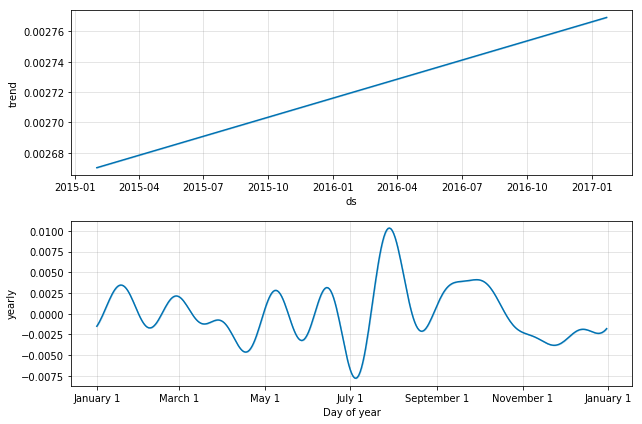

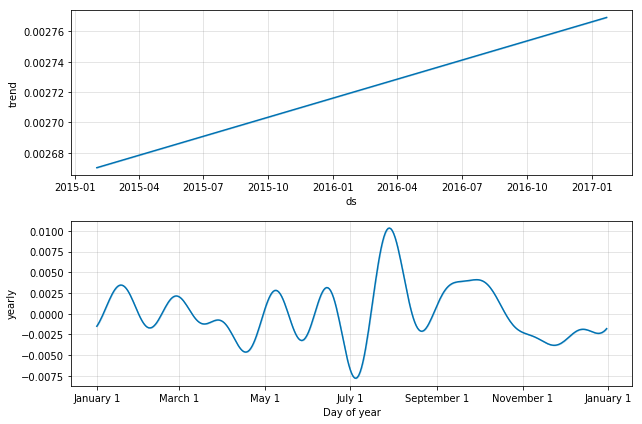

In [68]:
m.plot_components(forecast)
